In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import numpy as np
from glob import glob

In [2]:
from zipfile import ZipFile
file_name = "chest-ctscan-images.zip"

with ZipFile(file_name,'r') as zip1:
  zip1.extractall()
  print('Done')

Done


In [3]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
#no flip and zoom for test datase

In [4]:
batch_size = 22

In [5]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('chest-ctscan-images/Data/train',
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 44 images belonging to 4 classes.


In [6]:
training_set.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [7]:
# Make sure you provide the same target size as initialied for the image size
test_set = train_datagen.flow_from_directory('chest-ctscan-images/Data/test',
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 44 images belonging to 4 classes.


In [8]:
test_set.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [9]:
print(test_set.batch_size,test_set.batch_index, sep=', ')

22, 0


In [10]:
# Make sure you provide the same target size as initialied for the image size
valid_set = train_datagen.flow_from_directory('chest-ctscan-images/Data/valid',
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 44 images belonging to 4 classes.


In [11]:
valid_set.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [12]:
from tensorflow.keras.applications import Xception, VGG19, ResNet50V2, InceptionV3, MobileNetV2, DenseNet201, NASNetMobile,  EfficientNetV2S, ConvNeXtTiny


pre_trained_models = [
    Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
]

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [13]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

classify_models = []
for pretrained_model in pre_trained_models: 
    # The last 15 layers fine tune
    for layer in pretrained_model.layers[:-10]:
        layer.trainable = False

    x = pretrained_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.1)(x)
    output  = Dense(units=4, activation='softmax')(x)
    model = Model(pretrained_model.input, output)
    classify_models.append(model)


In [14]:
from tensorflow.python.keras.utils.layer_utils import count_params
import pandas as pd 

result_lst1 = []

for model, pre_model in zip(classify_models, pre_trained_models): 
    result_lst1.append({
        'Model Name': pre_model.name,
        'No of Layers': len(model.layers),
        'No of Conv layers': len([layer for layer in model.layers if 'conv' in layer.name]),
        'Total params': (str(model.count_params()/100000) + 'M'),
        'Trainable params': (str(count_params(model.trainable_weights)/100000) + 'M'),
        'Non-trainable params': (str(count_params(model.non_trainable_weights)/100000) + 'M')
    })
result_df1 = pd.DataFrame.from_dict(result_lst1)
result_df1 = result_df1.set_index('Model Name')
result_df1

,No of Layers,No of Conv layers,Total params,Trainable params,Non-trainable params
Model Name,,,,,
xception,139,111,221.75276M,68.10116M,153.6516M
vgg19,29,16,205.51748M,182.2618M,23.25568M
resnet50v2,197,182,248.78596M,47.2986M,201.48736M
inception_v3,318,94,231.1658M,13.13988M,218.02592M
mobilenetv2_1.00_224,161,5,31.78564M,16.5306M,15.25504M
densenet201,714,692,195.70244M,15.3466M,180.35584M
NASNet,776,372,50.75608M,8.06244M,42.69364M
efficientnetv2-s,520,110,212.5194M,18.42756M,194.09184M
convnext_tiny,140,131,284.78564M,54.23876M,230.54688M


In [15]:
import tensorflow as tf
import keras.losses

for model in classify_models: 
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9)
    model.compile(optimizer=optimizer1, loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [16]:
# fit the model
# Run the cell. It will take some time to execute
model_hist_lst = []
for model, pre_model in zip(classify_models, pre_trained_models): 
  print('Fitting Model: ', pre_model.name)
  hist = model.fit(
    training_set,
    validation_data=test_set,
    epochs=15,
    # steps_per_epoch=len(training_set),
    # validation_steps=len(test_set)
  )
  model_hist_lst.append(hist)
  print()

Fitting Model:  xception
Epoch 1/15


c:\Users\surya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - accuracy: 0.3333 - loss: 1.4844 - val_accuracy: 0.4091 - val_loss: 1.3086
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 5s/step - accuracy: 0.6818 - loss: 1.0051 - val_accuracy: 0.3409 - val_loss: 1.5172
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 5s/step - accuracy: 0.7424 - loss: 0.7741 - val_accuracy: 0.2955 - val_loss: 2.2312
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.8182 - loss: 0.5262 - val_accuracy: 0.3182 - val_loss: 3.0714
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - accuracy: 0.8182 - loss: 0.4548 - val_accuracy: 0.3864 - val_loss: 3.3948
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - accuracy: 0.9091 - loss: 0.3018 - val_accuracy: 0.3636 - val_loss: 4.2111
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 5s/step - accuracy: 0.9242 - loss: 0.2194 - val_accuracy: 0.3409 - val_loss: 5.0502
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.9848 - loss: 0.0962 - val_accuracy: 0.3409 - val_loss: 5.8376
Epoch 9/15
2/2 ━━━━━━━━━━━

In [17]:
# Validation set - True value preparation
pred_set = valid_set
n = len(pred_set)
input_lst = []
output_lst = []
for i in range(n): 
    set1 = next(training_set)
    input1 = set1[0]
    output1 = set1[1]
    y_true1 = np.argmax(output1, axis=1)
    input_lst.append(input1)
    output_lst.extend(y_true1)
input_arr = np.concatenate(input_lst)
output_lst = np.array(output_lst)
print(output_lst)
print(len(output_lst))
print(np.unique(output_lst, return_counts=True))


[1 1 2 3 2 0 1 3 2 0 2 2 1 0 2 2 2 3 0 0 3 0 1 1 0 3 1 1 0 3 3 2 3 1 2 1 3
 0 3 3 0 1 2 0]
44
(array([0, 1, 2, 3], dtype=int64), array([11, 11, 11, 11], dtype=int64))


In [18]:
# Predictions 
y_preds = []
for model, pre_model in zip(classify_models, pre_trained_models): 
    predictions = model.predict(input_arr)
    y_pred = np.argmax(predictions, axis=1)
    print('Model Name: ', pre_model.name)
    print('Predictions: ', y_pred)
    print('No of Predictions: ', len(y_pred))
    print('Predictions Class wise: ', np.unique(y_pred, return_counts=True))
    print()
    y_preds.append(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Model Name:  xception
Predictions:  [1 3 2 3 2 0 3 3 2 3 2 2 3 0 2 2 2 3 0 0 3 0 1 3 0 3 3 1 0 3 3 2 3 1 2 3 3
 0 3 3 0 3 2 0]
No of Predictions:  44
Predictions Class wise:  (array([0, 1, 2, 3], dtype=int64), array([10,  4, 11, 19], dtype=int64))

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Model Name:  vgg19
Predictions:  [3 3 2 3 2 2 2 2 2 2 2 2 3 2 2 2 2 2 3 2 2 3 3 3 2 2 2 3 2 3 3 2 3 3 2 3 2
 3 2 2 2 2 2 3]
No of Predictions:  44
Predictions Class wise:  (array([2, 3], dtype=int64), array([28, 16], dtype=int64))

1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000264A3B0BA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1),

In [19]:
target_names = [x[0] for x in sorted(pred_set.class_indices.items(), key=lambda x: x[1])]
print(target_names)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [112]:
# Evaluation Metrics
result_lst2 = []
result_lst3 = []
for model, pre_model, y_pred in zip(classify_models, pre_trained_models, y_preds):
    print('Model Name: ', pre_model.name)
    report = classification_report(output_lst, y_pred, target_names=target_names, zero_division=0.0)
    print(report) 
    print()
    report_dict = classification_report(output_lst, y_pred, target_names=target_names, output_dict=True, zero_division=0.0)
    result_lst2.append({
        'Model Name': pre_model.name,
        'accuracy': report_dict['accuracy'],
        'f1-score': report_dict['weighted avg']['f1-score'],
        'recall': report_dict['weighted avg']['recall'],
        'support': report_dict['weighted avg']['support']
    })

    tp_hsh = {
        'Model Name': pre_model.name
    }
    for class_name in target_names: 
        tp_hsh[class_name[:14] + '_f1-score'] = report_dict[class_name]['f1-score']
    result_lst3.append(tp_hsh)

result_df3 = pd.DataFrame.from_dict(result_lst3)
# result_df3 = result_df3.set_index('Model Name')

result_df2 = pd.DataFrame.from_dict(result_lst2)
result_df2 = result_df2.set_index('Model Name')
result_df = pd.merge(result_df1, result_df2, on=['Model Name'], how='outer')
result_df = result_df.sort_values(by=['f1-score'], ascending=[False])
result_df.to_markdown('model_comparison.md')
result_df.to_csv('model_comparison.csv')
result_df

Model Name:  xception
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       1.00      0.91      0.95        11
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       1.00      0.36      0.53        11
                                          normal       1.00      1.00      1.00        11
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.58      1.00      0.73        11

                                        accuracy                           0.82        44
                                       macro avg       0.89      0.82      0.80        44
                                    weighted avg       0.89      0.82      0.80        44


Model Name:  vgg19
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.00      0.00      0.00        11
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa      

,No of Layers,No of Conv layers,Total params,Trainable params,Non-trainable params,accuracy,f1-score,recall,support
Model Name,,,,,,,,,
densenet201,714,692,195.70244M,15.3466M,180.35584M,1.000000,1.000000,1.000000,44.0
inception_v3,318,94,231.1658M,13.13988M,218.02592M,0.977273,0.977226,0.977273,44.0
NASNet,776,372,50.75608M,8.06244M,42.69364M,0.931818,0.933095,0.931818,44.0
xception,139,111,221.75276M,68.10116M,153.6516M,0.818182,0.804762,0.818182,44.0
resnet50v2,197,182,248.78596M,47.2986M,201.48736M,0.795455,0.775641,0.795455,44.0
efficientnetv2-s,520,110,212.5194M,18.42756M,194.09184M,0.681818,0.690909,0.681818,44.0
mobilenetv2_1.00_224,161,5,31.78564M,16.5306M,15.25504M,0.659091,0.625972,0.659091,44.0
convnext_tiny,140,131,284.78564M,54.23876M,230.54688M,0.590909,0.592036,0.590909,44.0
vgg19,29,16,205.51748M,182.2618M,23.25568M,0.340909,0.215100,0.340909,44.0


<Axes: title={'center': 'Evaluation Metrics'}, xlabel='Model Name', ylabel='Score'>

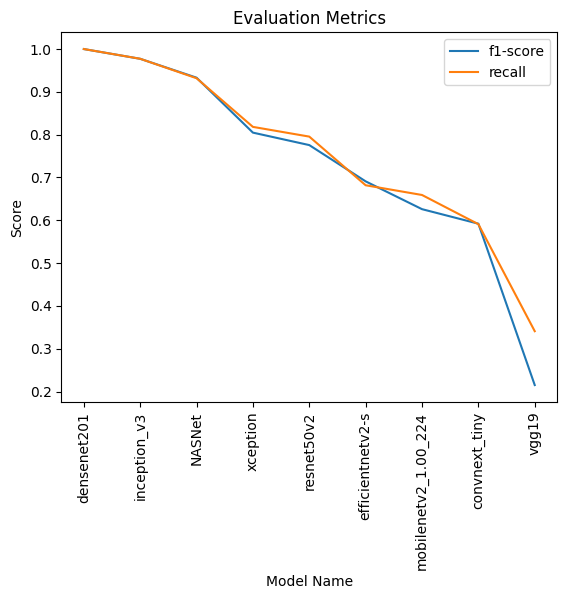

In [109]:
# Evaluation Metrics for each Model
ax1 = result_df[['f1-score', 'recall']].plot(title='Evaluation Metrics', rot=90, ylabel='Score')
plt.savefig('evaluation_metrics')
ax1

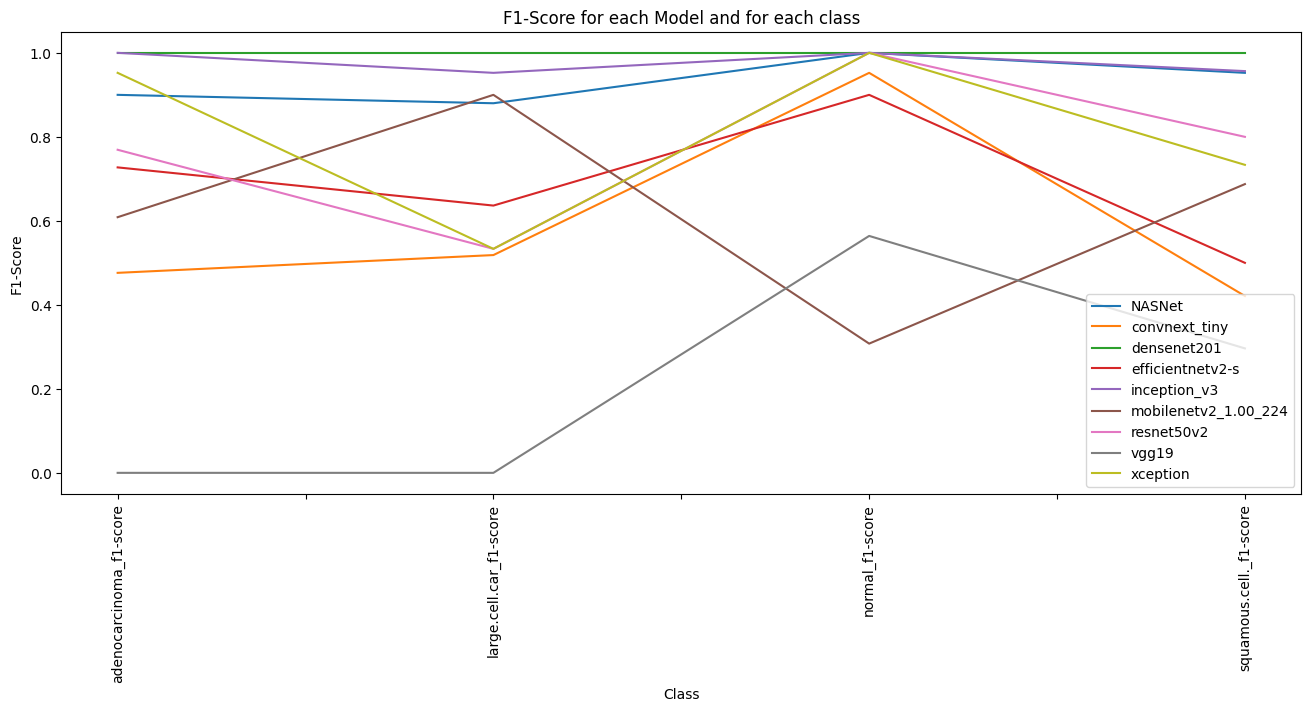

In [110]:
# F1-Score for each Model for each class
cols = result_df3.columns

result_df3_pivoted = result_df3.pivot_table(columns=['Model Name'])
ax2 = result_df3_pivoted.plot(title='F1-Score for each Model and for each class', rot=90, ylabel='F1-Score', xlabel='Class', figsize=(16,6)).legend(loc='lower right')
plt.savefig('model_vs_class_f1-score')
ax2

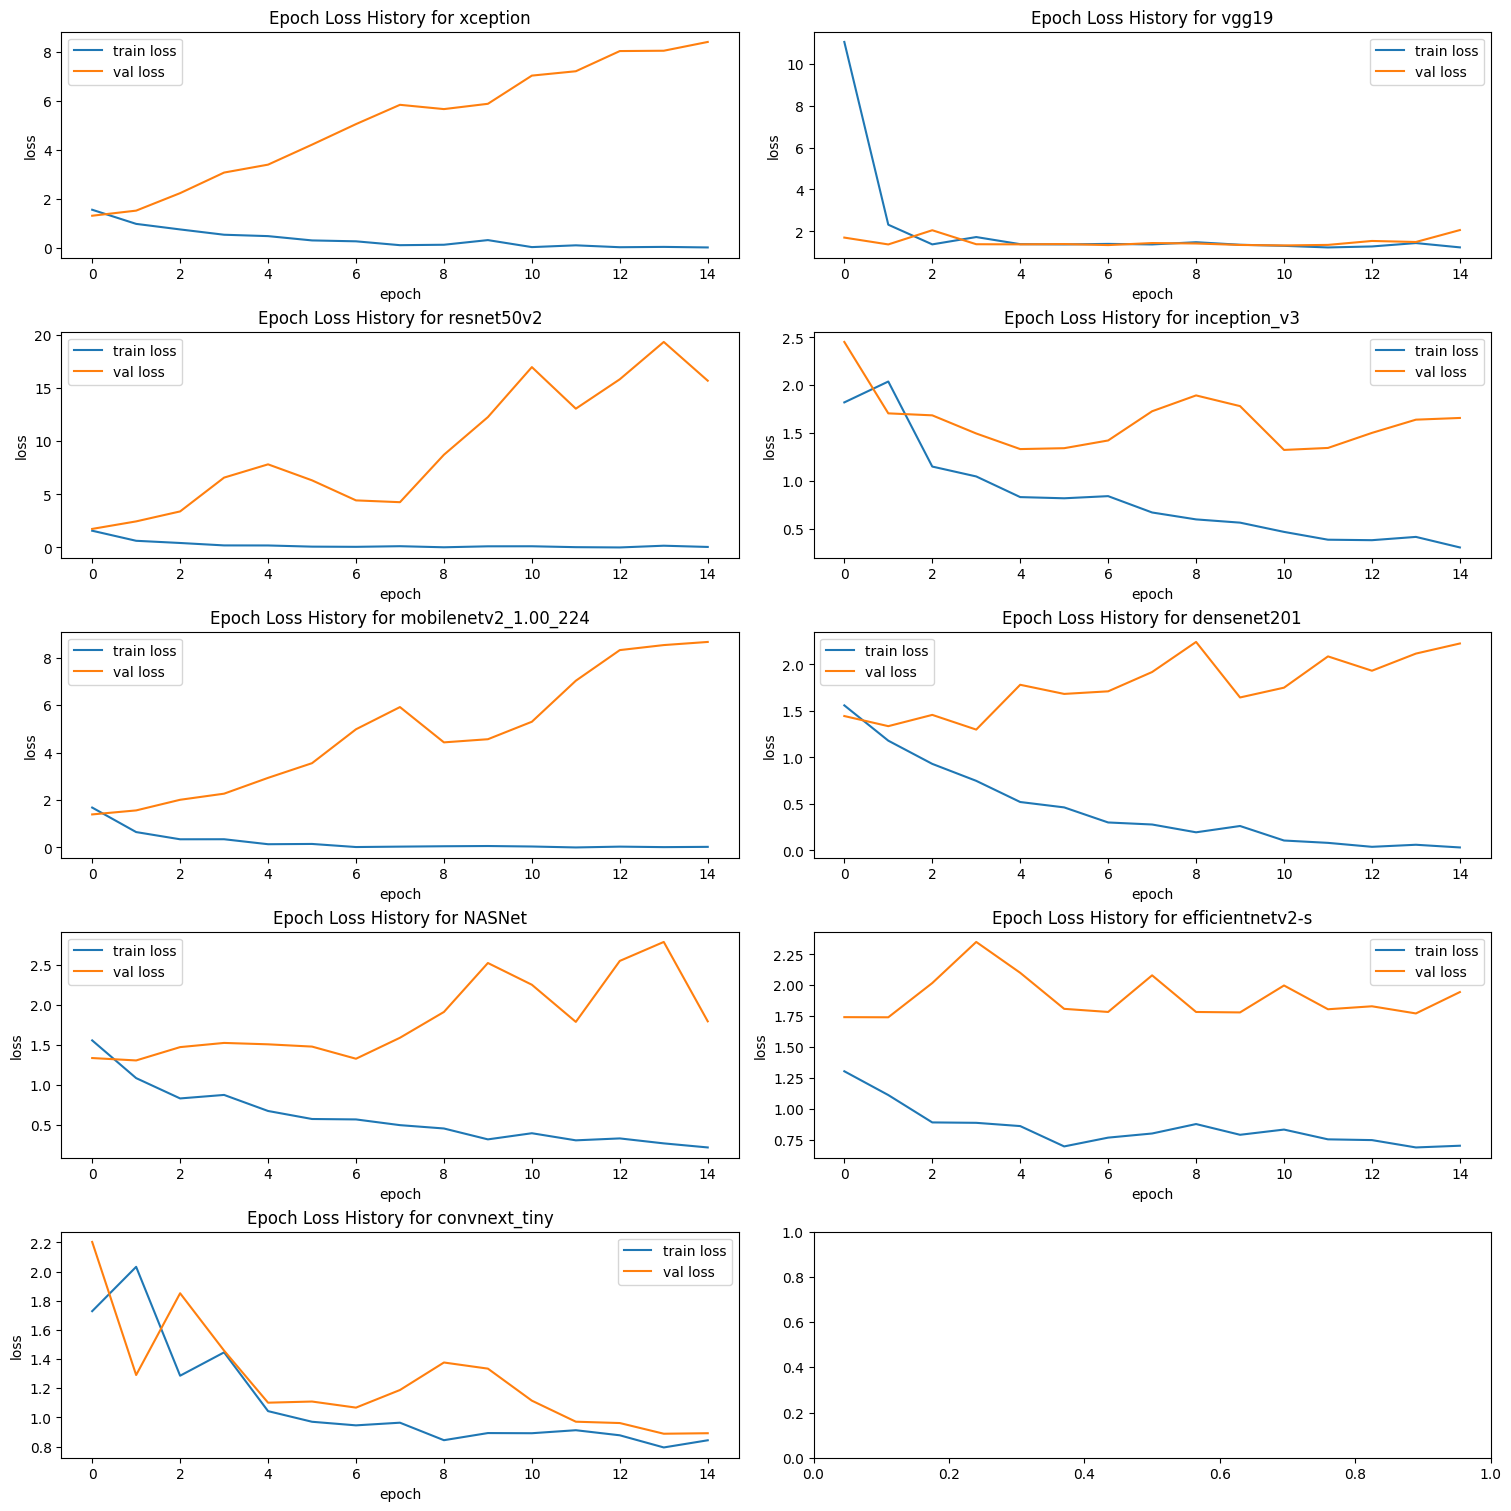

In [107]:
# Loss History
fig, axis_lst = plt.subplots(5,2, figsize=(15, 15), constrained_layout = True)
ind = 0
for hist, model, pre_model in zip(model_hist_lst, classify_models, pre_trained_models):
    # plot the loss
    i, j = int(ind/2), int(ind%2)
    axis_lst[i, j].plot(hist.history['loss'], label='train loss')
    axis_lst[i, j].plot(hist.history['val_loss'], label='val loss')
    axis_lst[i, j].legend()
    axis_lst[i, j].set_xlabel('epoch')
    axis_lst[i, j].set_ylabel('loss')
    axis_lst[i, j].set_title('Epoch Loss History for ' + pre_model.name)
    ind += 1
fig.savefig('LossVal_loss')
plt.show()


In [116]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

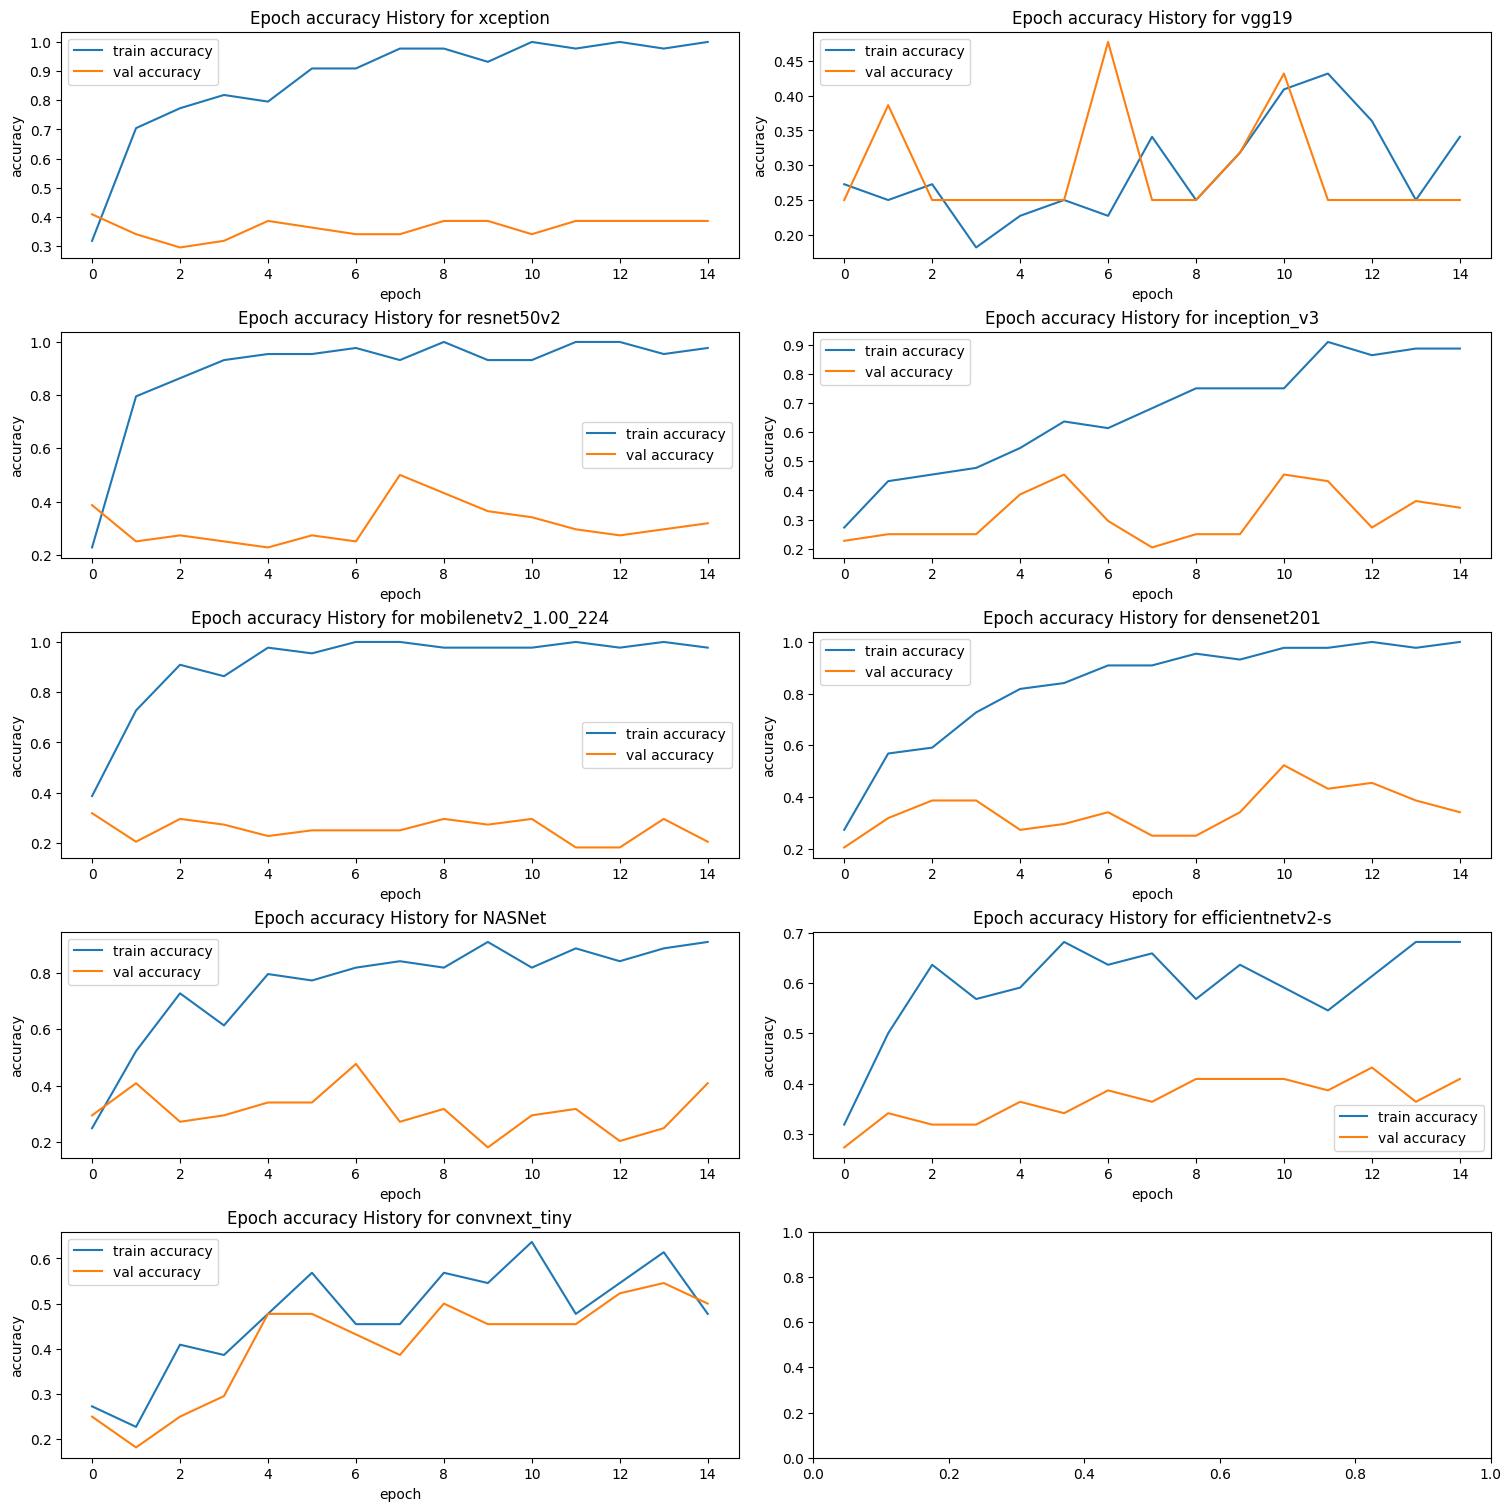

In [117]:
# Accuracy History
fig, axis_lst = plt.subplots(5,2, figsize=(15, 15), constrained_layout = True)
ind = 0
for hist, model, pre_model in zip(model_hist_lst, classify_models, pre_trained_models):
    # plot the loss
    i, j = int(ind/2), int(ind%2)
    axis_lst[i, j].plot(hist.history['accuracy'], label='train accuracy')
    axis_lst[i, j].plot(hist.history['val_accuracy'], label='val accuracy')
    axis_lst[i, j].legend()
    axis_lst[i, j].set_xlabel('epoch')
    axis_lst[i, j].set_ylabel('accuracy')
    axis_lst[i, j].set_title('Epoch accuracy History for ' + pre_model.name)
    ind += 1
fig.savefig('accuracyVal_accuracy')
plt.show()
